## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os,glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

import fastai

from fastai import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback


In [3]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

## Loading the Data

In [79]:
from numpy import genfromtxt
path_vad = '/path/to/dataset/IAPS/IAPS_VAD.txt'
mat_vad = pd.read_csv(path_vad,sep='\t',names=['image','v','a','d'])

In [80]:
mat_vad['image']=['/path/to/dataset/IAPS/Dataset/{}.jpg'.format(i) for i in mat_vad['image']]

In [81]:
mat_vad['v']=(mat_vad['v']-1)/8
mat_vad['a']=(mat_vad['a']-1)/8
mat_vad['d']=(mat_vad['d']-1)/8

In [82]:
mat_vad.head()

,image,v,a,d
0,/path/to/dataset/IAPS/Dataset/1019.jpg,0.36875,0.59625,0.40375
1,/path/to/dataset/IAPS/Dataset/1022.jpg,0.40750,0.62750,0.36250
2,/path/to/dataset/IAPS/Dataset/1026.jpg,0.38625,0.57625,0.42875
3,/path/to/dataset/IAPS/Dataset/1030.jpg,0.41250,0.55750,0.44500
4,/path/to/dataset/IAPS/Dataset/1033.jpg,0.35875,0.64125,0.34125


## Preparing the Data for Fastai Models

In [11]:
tfms = get_transforms(max_lighting=None, do_flip=True)

data_big = ImageList.from_df(mat_vad, '/', cols=['image'], folder ='.').split_by_rand_pct(0.01, seed=42).label_from_df(label_cls=FloatList,cols=['v','a','d']).transform(tfms, size=50).databunch(bs=10).normalize(imagenet_stats)

## Fastai Modelling

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet50(pretrained=True).children())[:-1]
        layers += [Flatten()]
        layers += [nn.Linear(2048,512),nn.ReLU(),nn.Linear(512,128),nn.ReLU(),nn.Linear(128,3)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out=self.model(x)
        return out
          # could add 116*torch.sigmoid

In [42]:
pred_l=[]
targ_l=[]

In [43]:
from fastai.torch_core import flatten_check
def root_mean_squared_error2(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    pred_l.append(pred)
    targ_l.append(targ)
    pred,targ = flatten_check(pred,targ)
    return torch.sqrt(F.mse_loss(pred, targ))
def flattened_MSE(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    if not model.training:
        print('MSE,',pred,targ)
    pred,targ = flatten_check(pred,targ)
    return F.mse_loss(pred, targ)

In [44]:
model = Model()

In [45]:
learn = Learner(data_big, model, model_dir = "/path/to/model/", bn_wd=False,metrics=[root_mean_squared_error,root_mean_squared_error2,flattened_MSE],
               callback_fns=[ShowGraph])

In [48]:
lr = 4e-5
wd = lr/7
epoch=100

epoch,train_loss,valid_loss,root_mean_squared_error,root_mean_squared_error2,flattened_MSE,time
0,0.035484,0.050125,0.222814,0.222814,0.050125,00:10


MSE, tensor([[0.9179, 0.6805, 0.9699],
        [0.4772, 0.5564, 0.5529],
        [0.4367, 0.4989, 0.5497],
        [0.5996, 0.6213, 0.6430],
        [0.5364, 0.5085, 0.5760],
        [0.4039, 0.4628, 0.4181],
        [0.5260, 0.4961, 0.5399],
        [0.6781, 0.7379, 0.7259],
        [0.7295, 0.6506, 0.7814],
        [0.4320, 0.3744, 0.4911]], device='cuda:0') tensor([[0.4800, 0.3325, 0.5575],
        [0.4812, 0.6900, 0.4437],
        [0.1375, 0.6913, 0.2550],
        [0.9100, 0.3875, 0.6438],
        [0.7912, 0.7937, 0.4625],
        [0.6525, 0.5013, 0.6137],
        [0.8175, 0.6687, 0.6463],
        [0.8163, 0.6175, 0.6025],
        [0.6862, 0.4775, 0.5825],
        [0.4712, 0.4825, 0.5188]], device='cuda:0')
MSE, tensor([[0.3288, 0.4562, 0.4181]], device='cuda:0') tensor([[0.7837, 0.5200, 0.6300]], device='cuda:0')


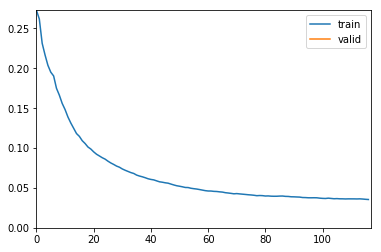

Better model found at epoch 0 with valid_loss value: 0.05012543499469757.


In [49]:
learn.fit(1, lr, wd=wd, callbacks=[SaveModelCallback(learn),EarlyStoppingCallback(learn,patience=4)])

In [69]:
pred_l#same as the input of MSE

[tensor([[0.9179, 0.6805, 0.9699],
         [0.4772, 0.5564, 0.5529],
         [0.4367, 0.4989, 0.5497],
         [0.5996, 0.6213, 0.6430],
         [0.5364, 0.5085, 0.5760],
         [0.4039, 0.4628, 0.4181],
         [0.5260, 0.4961, 0.5399],
         [0.6781, 0.7379, 0.7259],
         [0.7295, 0.6506, 0.7814],
         [0.4320, 0.3744, 0.4911]], device='cuda:0'),
 tensor([[0.3288, 0.4562, 0.4181]], device='cuda:0')]

In [51]:
targ_l#same as the input of MSE

[tensor([[0.4800, 0.3325, 0.5575],
         [0.4812, 0.6900, 0.4437],
         [0.1375, 0.6913, 0.2550],
         [0.9100, 0.3875, 0.6438],
         [0.7912, 0.7937, 0.4625],
         [0.6525, 0.5013, 0.6137],
         [0.8175, 0.6687, 0.6463],
         [0.8163, 0.6175, 0.6025],
         [0.6862, 0.4775, 0.5825],
         [0.4712, 0.4825, 0.5188]], device='cuda:0'),
 tensor([[0.7837, 0.5200, 0.6300]], device='cuda:0')]

In [52]:
x=[(pred_l[i]-targ_l[i])**2 for i in range(len(pred_l))]

In [71]:
#how 0.050125 (valid_loss) is calculated
(F.mse_loss(pred_l[0],targ_l[0])*len(pred_l[0])+F.mse_loss(pred_l[1],targ_l[1])*len(pred_l[1]))/(len(pred_l[0])+len(pred_l[1]))

tensor(0.0501, device='cuda:0')

In [72]:
#how 0.222814 (RMSE in metrics) is calculated
(F.mse_loss(pred_l[0],targ_l[0])**0.5*len(pred_l[0])+F.mse_loss(pred_l[1],targ_l[1])**0.5*len(pred_l[1]))/(len(pred_l[0])+len(pred_l[1]))

tensor(0.2228, device='cuda:0')

In [56]:
#MSE is correctly claculated
torch.mean(torch.cat(x))

tensor(0.0501, device='cuda:0')

In [83]:
#what i think the RMSE should be
torch.mean(torch.cat(x))**0.5

tensor(0.2239, device='cuda:0')